In this notebook, we're going to talk about different methods for summarizing time-series data in the frequency domain.


# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install os
!pip install mne
!pip install librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import mne
from IPython.display import Audio
import librosa as lr
import librosa.display

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.0 MB/s eta 0:00:00


In [2]:
!wget -Ncnp https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf

--2024-06-21 03:43:55--  https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘chb01_03.edf’

chb01_03.edf        100%[===================>]  40.44M   635KB/s    in 67s     

2024-06-21 03:45:02 (620 KB/s) - ‘chb01_03.edf’ saved [42399744/42399744]



In [3]:
# Keep track of useful information for the dataset
sampling_rate_hz = 256
eeg_col = 'FP1-F7'

# Read in the data and create a time column
edf = mne.io.read_raw_edf('chb01_03.edf')
df = pd.DataFrame(edf.get_data().T, columns=edf.ch_names)
df['Time'] = np.arange(0, df.shape[0])* (1/sampling_rate_hz)

# Rename and keep useful columns
keep_cols = ['Time', eeg_col]
df = df[keep_cols]
df.rename(columns={eeg_col: 'EEG'}, inplace=True)

# Split off useful chunks of the recording according to annotations
df = df[(df['Time']>=10) & (df['Time']<=15)]
df['Time'] = df['Time'] - df['Time'].min()
df.to_csv('eeg.csv',index=False)




Extracting EDF parameters from /content/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-3-950837a303ba>:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf('chb01_03.edf')


In [4]:
!wget -Ncnp https://physionet.org/files/sufhsdb/1.0.1/f1.wav

--2024-06-21 03:45:05--  https://physionet.org/files/sufhsdb/1.0.1/f1.wav
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2432684 (2.3M) [text/plain]
Saving to: ‘f1.wav’

f1.wav              100%[===================>]   2.32M   645KB/s    in 3.7s    

2024-06-21 03:45:09 (647 KB/s) - ‘f1.wav’ saved [2432684/2432684]



In [5]:
os.rename('f1.wav', 'heart_sound.wav')

# Frequency-Domain Features

For this notebook, we are going to look at a brief segment of EEG data recorded from a pediatric subject:

In [6]:
df = pd.read_csv('eeg.csv')
df.head()

,Time,EEG
0,0.000000,0.000060
1,0.003906,0.000068
2,0.007812,0.000074
3,0.011719,0.000080
4,0.015625,0.000081


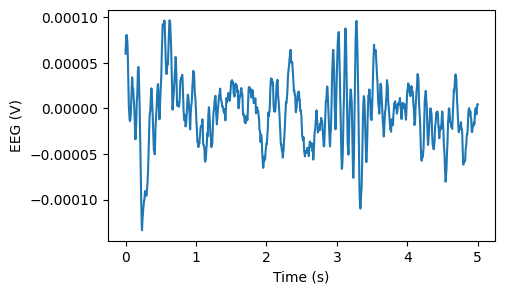

In [7]:
plt.figure(figsize=(5,3))
plt.plot(df['Time'], df['EEG'])
plt.xlabel('Time (s)')
plt.ylabel('EEG (V)')
plt.show()

In [8]:
time = df['Time'].values
eeg = df['EEG'].values

In [9]:
from numpy.fft import fftfreq
from scipy.fftpack import fft

# Compute the FFT
fs = 256
fft_mag = np.abs(fft(eeg))
freqs = fftfreq(len(eeg), 1/fs)

# Keep the components associated with positive frequencies
pos_freq_idxs = freqs >= 0
freqs = freqs[pos_freq_idxs]
fft_mag = fft_mag[pos_freq_idxs]

In some situations, an FFT can actually be considered a condensed representation of time-series data. However, there are other useful characteristics you can extract from an FFT.

## Frequency Measures

As we saw in our previous examples, it can be useful to identify the ***dominant (peak) frequency*** contained in the signal. For example, this could be used to identify the person's walking rate or tremor frequency in motion data:

In [10]:
def calc_peak_freq(freqs, fft_mag):
    peak_freq_index = fft_mag.argmax()
    peak_freq = freqs[peak_freq_index]
    return peak_freq

In [11]:
peak_freq = calc_peak_freq(freqs, fft_mag)
print(f'Dominant frequency: {peak_freq:0.2f} Hz')

Dominant frequency: 1.20 Hz


In some cases, there might be an arbitrary peak in the FFT and we would rather have a well-balanced way of identifying where most of the frequency content is located. The ***spectral centroid*** can help with that by reporting the center-of-mass (i.e., the weighted average) of the FFT:

In [12]:
def calc_spectral_centroid(freqs, fft_mag):
    return np.sum(freqs*fft_mag) / np.sum(fft_mag)

In [13]:
spectral_centroid = calc_spectral_centroid(freqs, fft_mag)
print(f'Spectral centroid: {spectral_centroid:0.2f} Hz')

Spectral centroid: 13.43 Hz


A way of summarizing the range of prominent frequencies  in a signal is by calculating the ***spectral rolloff***, which describes the frequency below which a certain percentage (often 85%) of the total power of the signal is contained. Power is calculated by squaring the magnitude of the FFT.

In [14]:
def calc_spectral_rolloff(freqs, fft_mag, cutoff):
    # Calculate the total power and the rolloff threshold
    power = fft_mag ** 2
    power_cutoff = cutoff*np.sum(power)

    # Identify the frequency that corresponds to the cutoff point
    cumulative_sum = np.cumsum(power)
    closest_idx = np.argmin(np.abs(cumulative_sum - power_cutoff))
    return freqs[closest_idx]

In [15]:
spectral_rolloff = calc_spectral_rolloff(freqs, fft_mag, 0.85)
print(f"Spectral rolloff at 50%: {calc_spectral_rolloff(freqs, fft_mag, 0.50):0.2f} Hz")
print(f"Spectral rolloff at 75%: {calc_spectral_rolloff(freqs, fft_mag, 0.75):0.2f} Hz")
print(f"Spectral rolloff at 90%: {calc_spectral_rolloff(freqs, fft_mag, 0.90):0.2f} Hz")

Spectral rolloff at 50%: 3.40 Hz
Spectral rolloff at 75%: 9.39 Hz
Spectral rolloff at 90%: 11.59 Hz


Putting these features altogether, here is a graph showing the dominant frequency, spectral centroid, and spectral rolloff on the FFT of our signal.

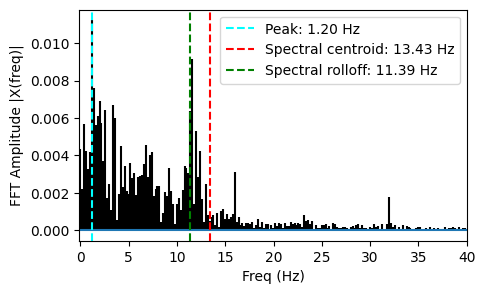

In [16]:
plt.figure(figsize=(5,3))
plt.stem(freqs, fft_mag, linefmt="black", markerfmt=" ", basefmt="-")
plt.axvline(peak_freq, 0, 1, linestyle="--", color="cyan", label=f"Peak: {peak_freq:0.2f} Hz")
plt.axvline(spectral_centroid, 0, 1, linestyle ="--", color ="red", label=f"Spectral centroid: {spectral_centroid:0.2f} Hz")
plt.axvline(spectral_rolloff, 0, 1, linestyle ="--", color ="green", label=f"Spectral rolloff: {spectral_rolloff:0.2f} Hz")
plt.legend()
plt.xlim(-0.1, 40)
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

## Magnitude Measures

We can calculate the overall intensity of the signal (***total power***) by taking the sum of the squared magnitudes across the entire FFT:

In [17]:
def total_power(freqs, fft_mag):
    return np.sum(fft_mag**2)

In [18]:
print(f'Total power: {total_power(freqs, fft_mag)} V^2')

Total power: 0.001075312243253156 V^2


Since the units for signal power can be unintuitive, we can calculate the ***log ratio between the power of frequency bands*** in order to get a relativistic understanding of how much more prominent one set of frequencies is compared to another. The bands that are used for this calculation can be arbitrary. The example below separates the frequencies into *low* and *high* categories:

In [19]:
def freq_ratio(freqs, fft_mag, cutoff):
    # Create binary masks that determine which frequencies are low and high
    low_freqs = freqs < cutoff
    high_freqs = freqs >= cutoff

    # Calculate the power of those respective frequencies
    low_freq_mag = np.sum(fft_mag[low_freqs]**2)
    high_freq_mag = np.sum(fft_mag[high_freqs]**2)

    # Return the log ratio in decibels
    return 10*np.log10(high_freq_mag / low_freq_mag)

In [20]:
print(f"Ratio at 1 Hz: {freq_ratio(freqs, fft_mag, 1)} dB")
print(f"Ratio at 2 Hz: {freq_ratio(freqs, fft_mag, 2)} dB")
print(f"Ratio at 5 Hz: {freq_ratio(freqs, fft_mag, 5)} dB")

Ratio at 1 Hz: 9.791917970115868 dB
Ratio at 2 Hz: 2.2260082001969255 dB
Ratio at 5 Hz: -1.52099287736546 dB


# Computing Features from Spectrograms

Recall that a spectrogram is simply a sequence of FFTs computed over a subset of shorter time windows. This means that all of the features we covered can be applied to a spectrogram by iterating over the time dimension and applying the calculation on each window.

To demonstrate this point, let's calculate the peak frequency over time in a spectrogram:

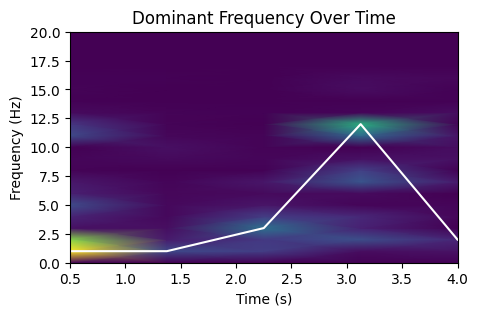

In [21]:
from scipy import signal
# Compute the spectrogram
freqs, times, spectro = signal.spectrogram(eeg, fs)

# Iterate through the spectrogram
peak_freqs = []
for t in range(spectro.shape[1]):
    # Grab the FFT at each time
    fft_mag = spectro[:, t]

    # Calculate the peak frequency at that time
    peak_freq = calc_peak_freq(freqs, fft_mag)
    peak_freqs.append(peak_freq)

# Show the signal in the frequency domain
plt.figure(figsize=(5,3))
plt.pcolormesh(times, freqs, spectro, shading='gouraud')
plt.plot(times, peak_freqs, color='white')
plt.ylim(0, 20)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Dominant Frequency Over Time')
plt.show()

# Data Processing with Libraries

As was the case with our time-series features, there are many data science libraries that provide functions and methods for us. Some are included in libraries we have already seen (e.g., `numpy` and `scipy`). However, we are getting to the point where the information we are extracting requires a bit of domain specialization, which might lead you into finding other libraries.

For example, the `librosa` library is particularly popular for working with audio time-series data. In fact, `librosa` even has its own function for computing a spectrogram and functions that operate on thoes spectrograms. Here are some examples of `librosa` in action:

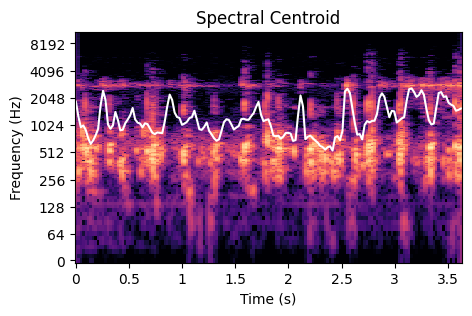

In [22]:
# Load the data and compute the spectrogram
y, fs = librosa.load('heart_sound.wav', sr=16000, mono=True,
                     offset=25, duration=5)
freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)
spec_mag = np.abs(D)

# Compute spectral rolloff and spectral centroid over time
spectral_centroid = librosa.feature.spectral_centroid(S=spec_mag, freq=freqs)
times = librosa.times_like(spectral_centroid)

# Show everything on the spectrogram
plt.figure(figsize=(5,3))
librosa.display.specshow(librosa.amplitude_to_db(S=spec_mag, ref=np.max),
                         y_axis='log', x_axis='time')
plt.plot(times, spectral_centroid.T, color='w')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid')
plt.show()